 **Financial assets trend prediction using Machine Learning**


# Contents

1. Financial Data and Bars 
 - Form Bars
 - Summary and plot


2. Momentum Labeling
 - Trend Scanning
 - FB Prophet
 - Forward price movements


3. Prediction Model

 3.1. Get Features (X)
 - Market data & Technical Analysis & Microstructure Features
 - Sentiments with NLP
 
 3.2. Feature Engineering
 - Feature Scaling (MinMaxScaler)
 - Dimension Reduction (PCA/ Non Linear Autoencoder)
 
 3.3. Machine Learning Model
 - AutoML with *autogluon* and select the best model
 - Cross-Validation
 - Feature Importance

In [1]:
# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('tableau-colorblind10')

#feature
from sklearn import preprocessing
from sklearn.decomposition import PCA 

#ML
import autogluon as ag

# deep learning
import keras

# Technical analysis
import ta
from features import getTA, tautil, ti_matrix

from labeling import trend_scanning
import fbprophet

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
def figure_scatter(sc,close, title, vmin=None, vmax=None, cmap='bwr', figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.plot(close, linewidth=0.5,alpha=0.6)
    if (vmin==None) & (vmax==None):
        plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap=cmap, alpha=1)
    else:
        plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap=cmap, alpha=1,vmin=vmin,vmax=vmax)
    plt.colorbar()
    plt.title(title)
    plt.savefig('image/{}.png'.format(title))
    plt.show()

# Financial Data and Bars

## Form bars

- Asset: ETH/USD 
- 5 minute data

In [4]:
df_raw = pd.read_csv('C:data/ethusd5min.csv')
df = df_raw.set_index('timestamp')
df.index = pd.to_datetime(df.index)

In [5]:
df

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2019-01-01 00:00:00,131.45,131.54,131.01,131.27,1269.12705,1546301099999,1.666154e+05,404,583.71526,7.665267e+04,0
2019-01-01 00:05:00,131.26,131.35,131.12,131.29,1601.91843,1546301399999,2.102706e+05,329,970.39345,1.273754e+05,0
2019-01-01 00:10:00,131.27,131.36,131.19,131.31,560.54337,1546301699999,7.359844e+04,255,237.78679,3.121957e+04,0
2019-01-01 00:15:00,131.30,131.36,131.25,131.30,651.89505,1546301999999,8.559326e+04,203,173.81466,2.282429e+04,0
2019-01-01 00:20:00,131.26,131.44,131.25,131.28,500.58218,1546302299999,6.572714e+04,275,232.22948,3.049598e+04,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13 23:40:00,1941.97,1943.71,1940.34,1943.25,392.24754,1626219899999,7.618761e+05,925,265.19319,5.150956e+05,0
2021-07-13 23:45:00,1943.24,1943.24,1932.66,1933.79,1233.82503,1626220199999,2.389417e+06,2173,612.61804,1.186551e+06,0
2021-07-13 23:50:00,1933.79,1935.73,1931.38,1933.40,1011.00253,1626220499999,1.954553e+06,1957,498.29748,9.634496e+05,0


In [6]:
# Considering Computing costs
df = df.loc['2020-12':,:]

In [7]:
buy_volume = pd.to_numeric(df.tb_base_av)

## summary & plots

In [9]:
df_ohlcv = tautil.ohlcv(df)
df_ohlcv = df_ohlcv.join(buy_volume)
df_ohlcv.describe()

,open,high,low,close,volume,tb_base_av
count,64624.000000,64624.000000,64624.000000,64624.000000,64624.000000,64624.000000
mean,1871.174124,1876.288619,1865.949650,1871.192039,4018.844693,2000.216864
std,805.278023,807.783261,802.714411,805.264651,4109.274338,2046.519462
min,531.030000,534.800000,530.430000,531.050000,0.000000,0.000000
25%,1327.760000,1331.397500,1324.112500,1327.747500,1727.413917,845.630002
50%,1831.390000,1834.530000,1828.280000,1831.400000,2780.814780,1372.895910
75%,2339.937500,2346.620000,2333.222500,2339.967500,4712.020050,2364.972427
max,4360.460000,4372.720000,4350.010000,4360.460000,97220.826680,34123.452310


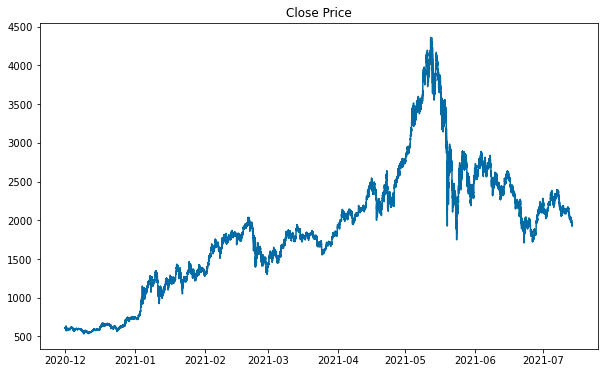

In [9]:
plt.figure(figsize=(10,6))
plt.title('Close Price')
plt.plot(close)
plt.savefig('image/close_price.jpg')
plt.show();

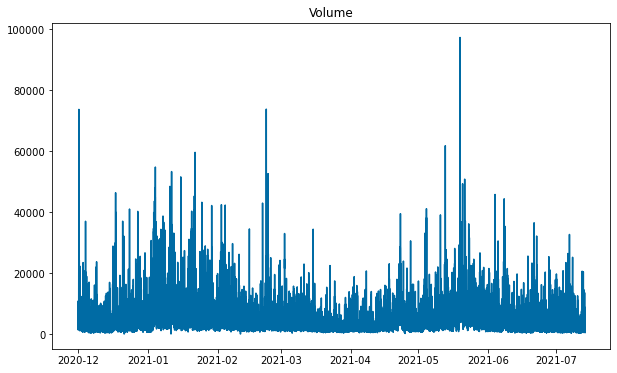

In [10]:
plt.figure(figsize=(10,6))
plt.title('Volume')
plt.plot(volume)
plt.savefig('image/volume.jpg')
plt.show();

In [11]:
of = buy_volume - (volume-buy_volume)

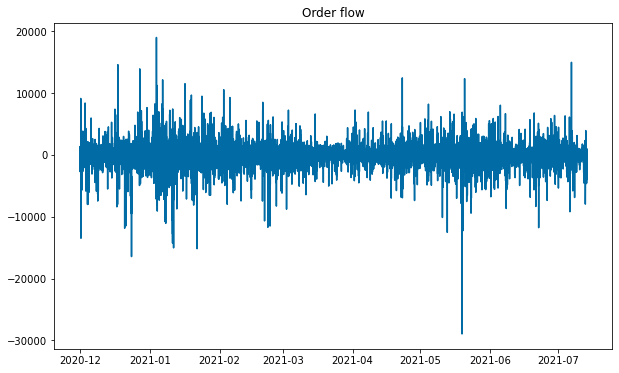

In [12]:
plt.figure(figsize=(10,6))
plt.title('Order flow')
plt.plot(of)
plt.savefig('image/order_flow.jpg')
plt.show();

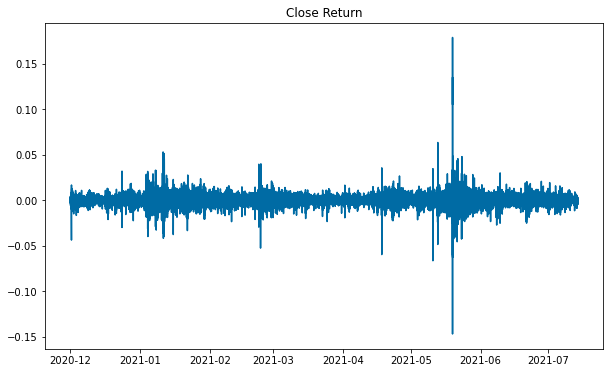

In [13]:
plt.figure(figsize=(10,6))
plt.title('Close Return')
plt.plot(close.pct_change())
plt.savefig('image/closereturn.jpg')
plt.show();

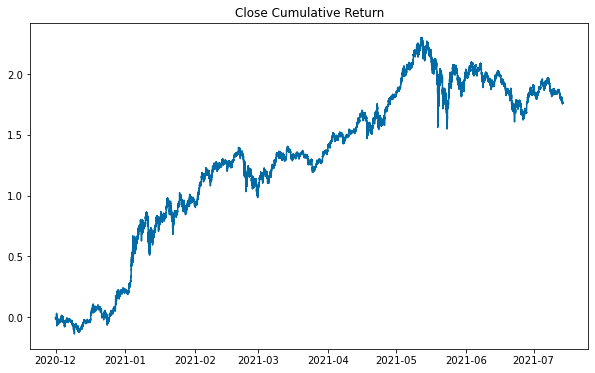

In [14]:
plt.figure(figsize=(10,6))
plt.title('Close Cumulative Return')
plt.plot(np.cumsum(close.pct_change()))
plt.savefig('image/closecumreturn.jpg')
plt.show();

# Trend Labeling 

## Trend scanning

In [15]:
trend_df_ = trend_scanning.trend_scanning_labels(close,step=10)

In [16]:
trend_df = trend_df_[['t_value','bin']]

In [17]:
trend_bin = trend_df.bin.copy()

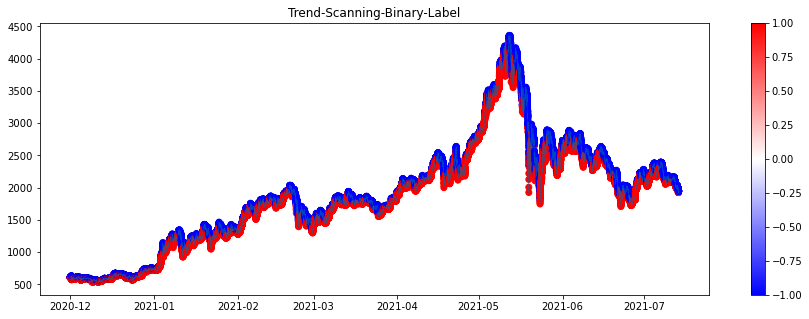

In [18]:
sc = trend_bin
title = 'Trend-Scanning-Binary-Label'

figure_scatter(sc,close,title)

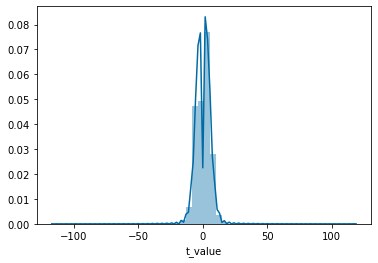

In [19]:
sns.distplot(trend_df.t_value.round())

In [20]:
trend_q = pd.qcut(trend_df.t_value,q=5,labels=[-2,-1,0,1,2],retbins=True)[0]

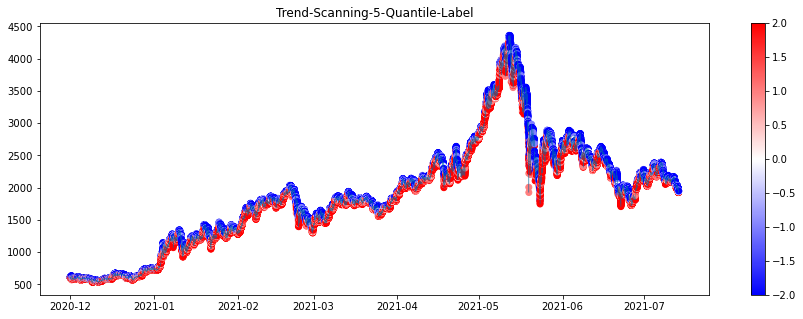

In [21]:
sc = trend_q
title = 'Trend-Scanning-5-Quantile-Label'

figure_scatter(sc,close,title)

# Prediction Model

For feature engineering we have to split train and test periods.

In [22]:
y = trend_bin.copy().rename('y').to_frame()
train_y = y.loc[:'2021-4-1',:]
test_y = y.loc['2021-4-1':,:]

 ## Get Features (X)
 
 ###  Market data

Market
- Techincal indicators with market data


In [23]:
df_ = df_ohlcv

In [24]:
windows = [20,40,60]
ti_signal = ti_matrix.get_all_signal(df_,windows)

In [25]:
mkt = ti_signal.copy()

for i in [1,5,10,30]:
    mkt = mkt.join(volume.diff(i).rename('vol_mom_{}'.format(i)))
    mkt = mkt.join(of.diff(i).rename('of_mom_{}'.format(i)))
    mkt = mkt.join(close.diff(i).rename('mom_{}'.format(i)))
    
for i in [5,30,60,100]:
    mkt = mkt.join(close.rolling(i).std().rename('std_{}'.format(i)))
    mkt = mkt.join(volume.rolling(i).std().rename('vol_std_{}'.format(i)))

In [26]:
mts= [5,10,30,60] #multipliers
TA = getTA.get_ta_window1(df_, mts)
mkt = mkt.join(TA)

Market Microstructures


In [27]:
# For bar data
from features import microstructure_features as mf

In [28]:
kyle_l = mf.get_bar_based_kyle_lambda(close,volume).rename('kyle_lambda')
bpv = mf.get_bekker_parkinson_vol(high,low).rename('bekker_parkinson_vol')
corwin = mf.get_corwin_schultz_estimator(high,low).rename('corwin_schultz_estimator')
vpin = mf.get_vpin(volume, buy_volume).rename('vpin')

micro_features = pd.concat([kyle_l,bpv,corwin,vpin],axis=1)

mkt = mkt.join(micro_features)

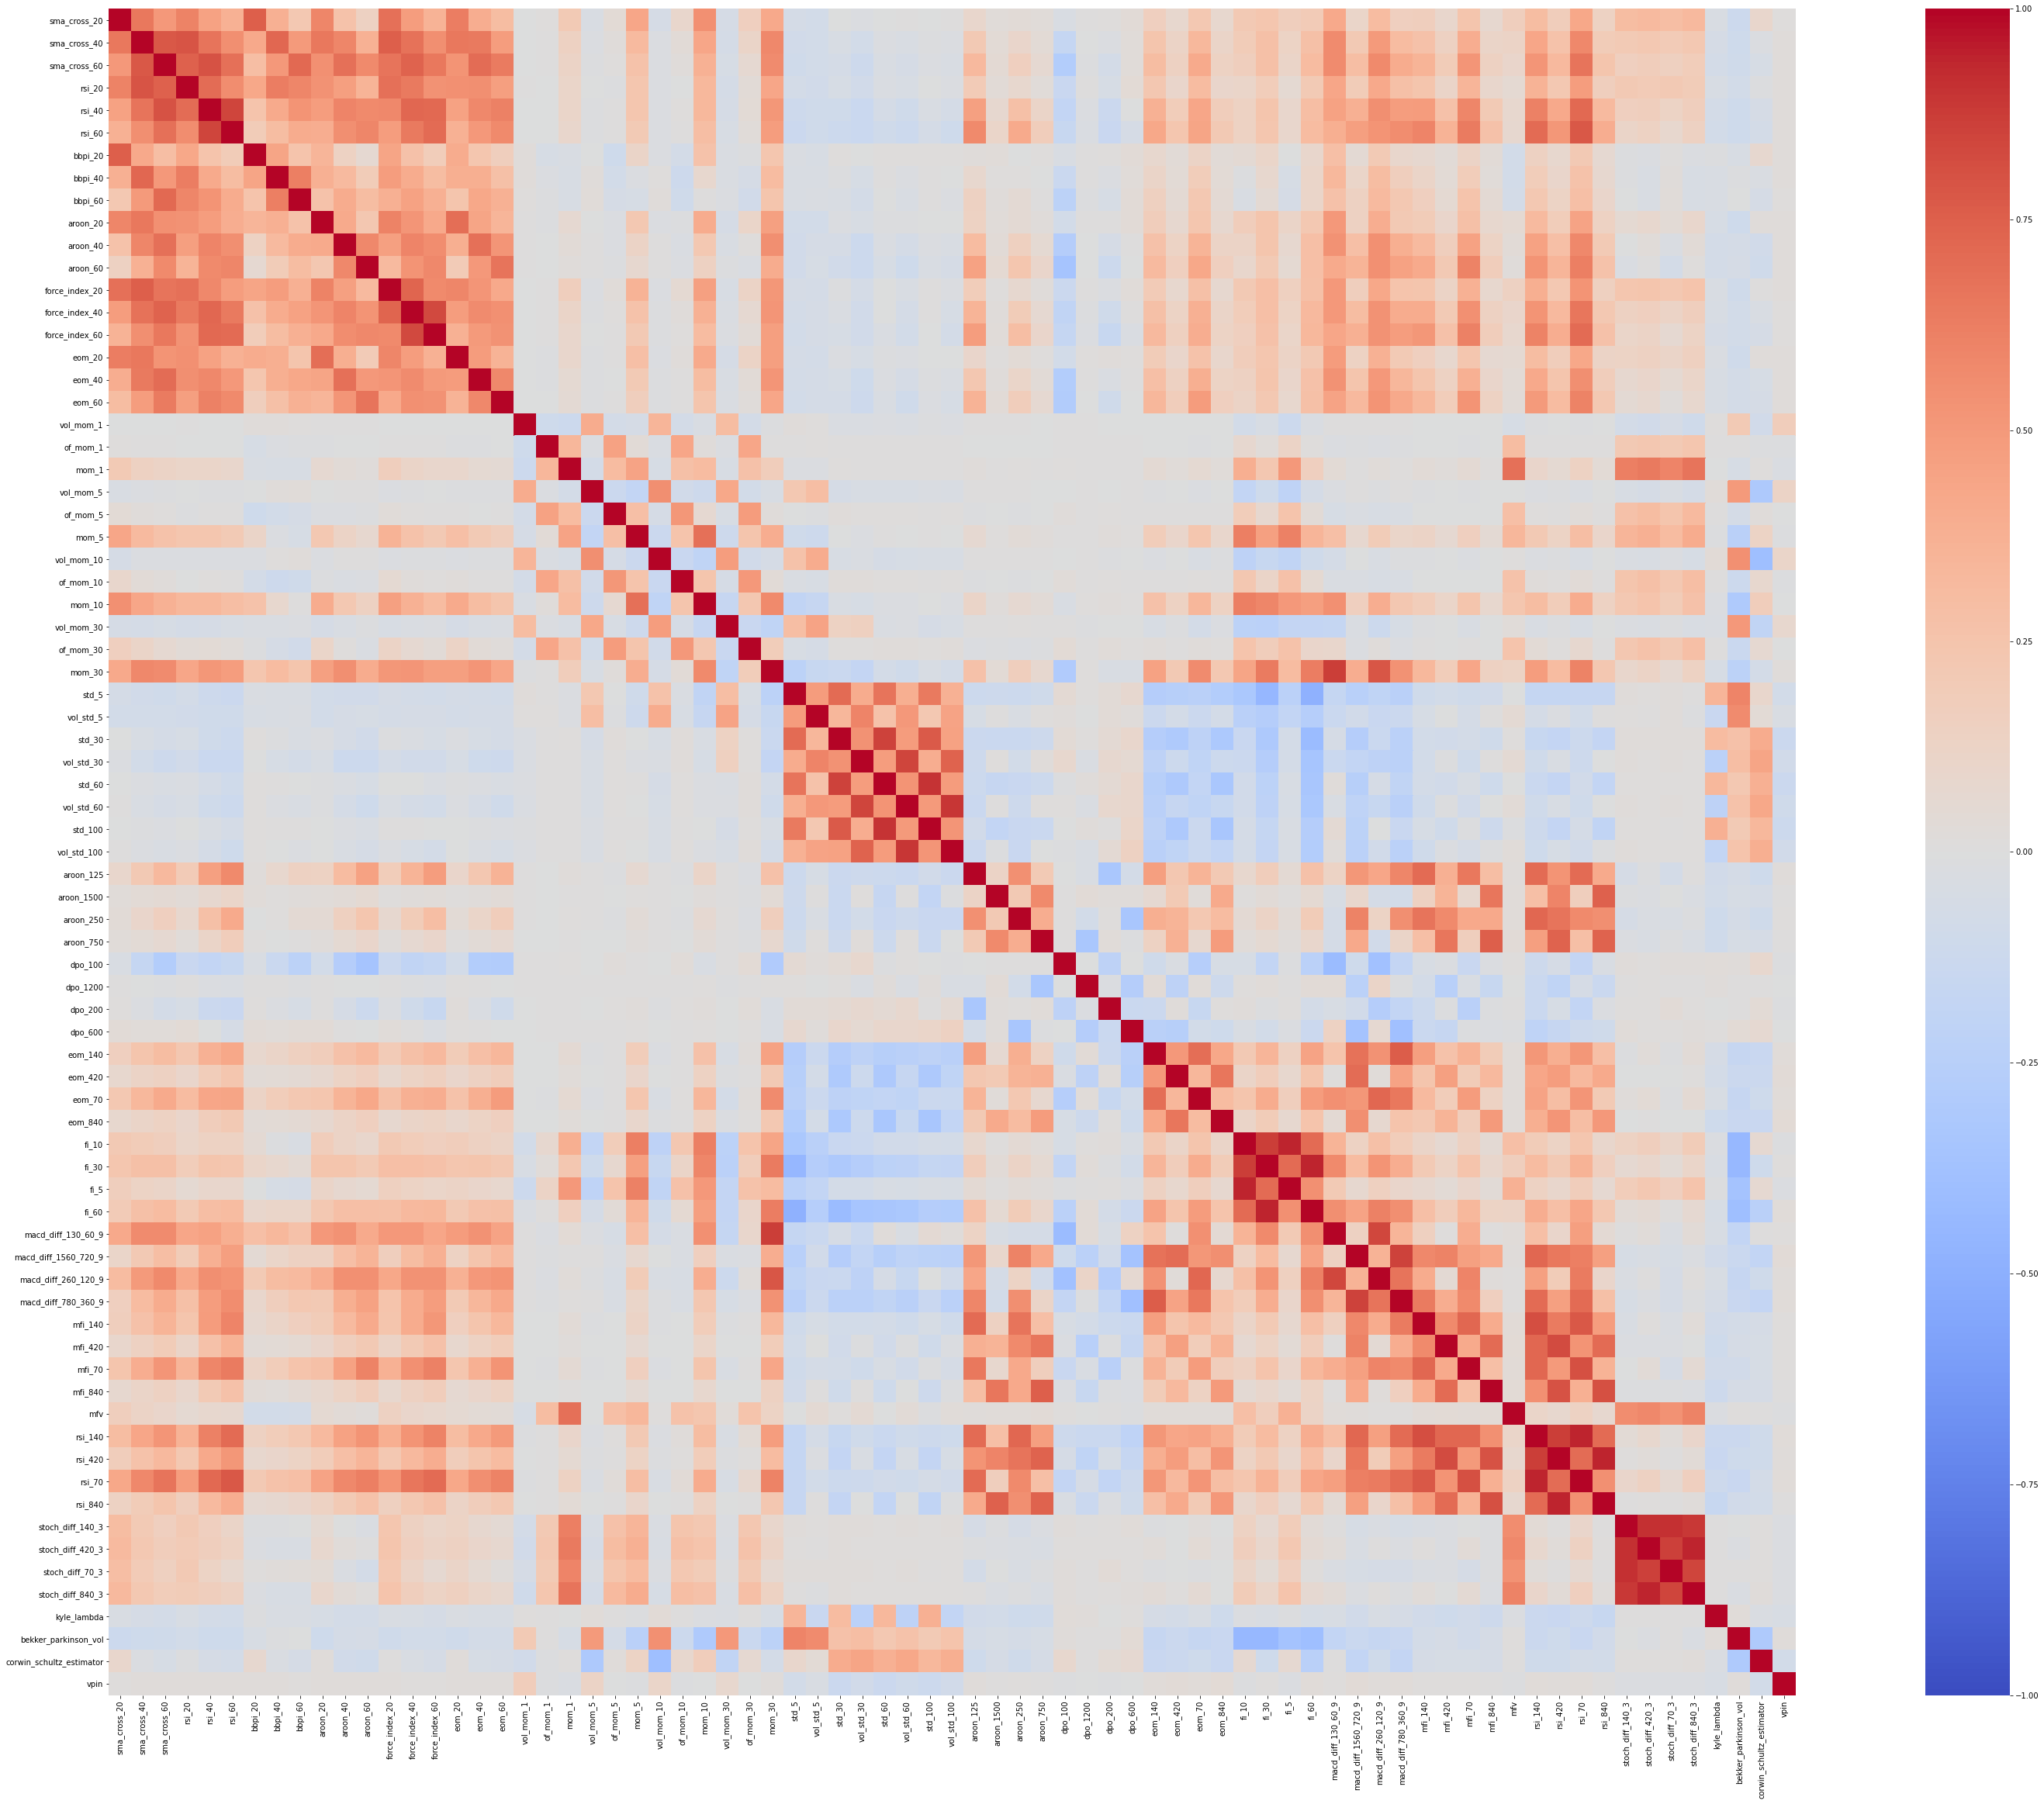

In [29]:
corr = mkt.corr()

plt.figure(figsize=(60,40))
sns.heatmap(corr, cmap='coolwarm', vmin=-1,vmax=1, square=True)
plt.savefig('image/feature_corr.png')
plt.show()

In [30]:
# Highly correlated market features

h = 0.75
where = (abs(corr)>h) & (corr<1)

hc_list =[]
for i in range(len(np.where(where)[0])):
    hc_list.append(sorted([corr.columns[np.where(where)[0][i]], corr.columns[np.where(where)[1][i]]]))
hc_list = np.array(sorted(hc_list))[::2,:]
hc_list

array([['aroon_750', 'mfi_840'],
       ['bbpi_20', 'sma_cross_20'],
       ['eom_140', 'macd_diff_780_360_9'],
       ['fi_10', 'fi_30'],
       ['fi_10', 'fi_5'],
       ['fi_30', 'fi_60'],
       ['force_index_20', 'sma_cross_40'],
       ['force_index_40', 'force_index_60'],
       ['macd_diff_130_60_9', 'macd_diff_260_120_9'],
       ['macd_diff_130_60_9', 'mom_30'],
       ['macd_diff_1560_720_9', 'macd_diff_780_360_9'],
       ['macd_diff_260_120_9', 'mom_30'],
       ['mfi_140', 'rsi_140'],
       ['mfi_140', 'rsi_70'],
       ['mfi_420', 'rsi_420'],
       ['mfi_70', 'rsi_70'],
       ['mfi_840', 'rsi_420'],
       ['mfi_840', 'rsi_840'],
       ['rsi_140', 'rsi_420'],
       ['rsi_140', 'rsi_70'],
       ['rsi_20', 'sma_cross_40'],
       ['rsi_40', 'rsi_60'],
       ['rsi_40', 'sma_cross_60'],
       ['rsi_420', 'rsi_840'],
       ['rsi_60', 'rsi_70'],
       ['sma_cross_40', 'sma_cross_60'],
       ['std_100', 'std_30'],
       ['std_100', 'std_60'],
       ['std_30', 'std_

### Sentiments

We can get features from Natural Language Process.

Working on this.

In [31]:
## OVERALL

In [32]:
raw_X = mkt.shift(1).copy()

In [33]:
'''
for i in raw_X.columns:
    plt.figure(figsize=(5,0.5))
    plt.plot(raw_X[i])
    plt.legend([i])
'''

'\nfor i in raw_X.columns:\n    plt.figure(figsize=(5,0.5))\n    plt.plot(raw_X[i])\n    plt.legend([i])\n'

## Feature Engineering

### Feature Scaling

Do it train, test data seperately.
I fit the scaler only on the training dataset and then transform the test set.

*Due to computational cost (in autoencoders), I did scaling and dimension-reduction of index of meta-labels'.*


MINMAX

In [34]:
train_index = y.loc[:'2021-4']
test_index = y.loc['2021-4':]

In [35]:
raw_X_train = raw_X.loc[train_index.index].dropna()
raw_X_test = raw_X.loc[test_index.index].dropna()

In [36]:
scaler = preprocessing.MinMaxScaler((0,1))
scaler.fit(raw_X_train)

scaled_X_train = pd.DataFrame(scaler.transform(raw_X_train),index=raw_X_train.index,columns=raw_X.columns)
scaled_X_test = pd.DataFrame(scaler.transform(raw_X_test),index=raw_X_test.index,columns=raw_X.columns)

### Dimension Reduction
- PCA - linear
- Deep Autoencoder (in process) - non-linear

CNN-autoencoder

https://github.com/jo-cho/machine-learning-for-trading/blob/master/18_convolutional_neural_nets/07_cnn_for_trading.ipynb

https://github.com/jo-cho/ML_Finance_Codes/blob/master/Chapter8-Advanced-NNs/ML_in_Finance-RNNs-Bitcoin.ipynb

In [37]:
# PCA
n=5

pca = PCA(n)
pca.fit(scaled_X_train)

pca_X_train = pd.DataFrame(pca.transform(scaled_X_train),columns = ['pc_{}'.format(i) for i in range(n)], index=scaled_X_train.index)

pca_X_test = pd.DataFrame(pca.transform(scaled_X_test),columns = ['pc_{}'.format(i) for i in range(n)], index=scaled_X_test.index)

In [38]:
components_ = pca.components_

In [39]:
loadings = pd.DataFrame(components_, index = pca_X_train.columns, columns=mkt.columns).T

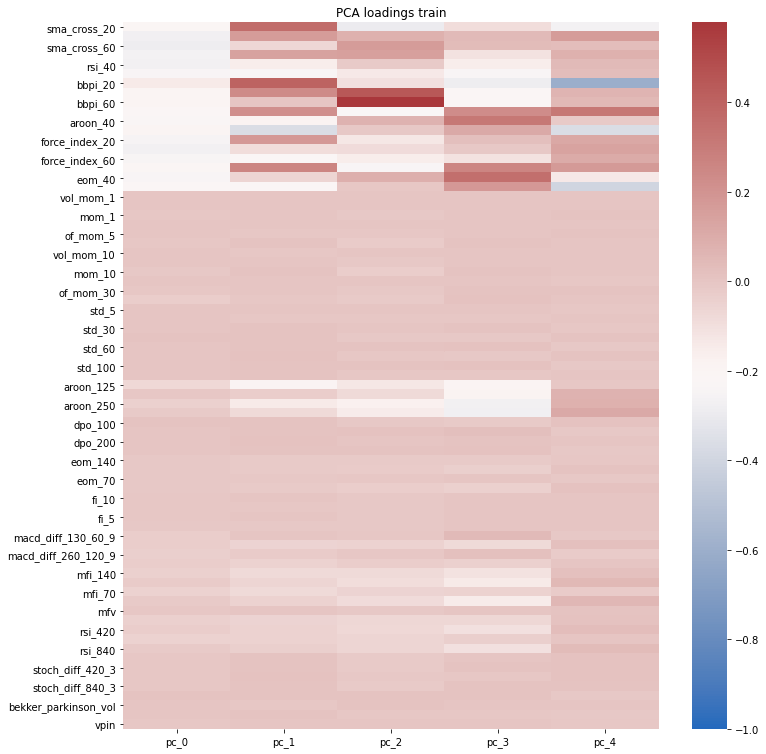

In [40]:
f = plt.figure(figsize=(12, 13))
sns.heatmap(loadings,cmap='vlag',vmin=-1)
plt.title('PCA loadings train')
plt.savefig('image/pcaloadings.jpg')
plt.show();

look out for binary features

# Machine Learning Model

## Hyper parameter tuning

In [41]:
train_X = scaled_X_train.copy()
# or
#train_X= pca_X_train.copy()

test_X = scaled_X_test.copy()
# or
#test_X= pca_X_test.copy()<Increasing p (probability of winning)>

FYI using encoded_X, the best precision score of auto ML models is around 0.66

In [42]:
train_data = train_X.join(train_y).dropna()
test_data = test_X.join(test_y).dropna()

## AutoML with autogluon and select the best model

In [43]:
from autogluon.tabular import TabularPredictor

This *autogluon* supports a number of machine learning models, and automatically chooses optimal hyperparameters given which score to be optimized.

And also it does CV, but not Purged K-Fold which was suggested by De Prado

In [44]:
predictor = TabularPredictor(label='y', eval_metric='accuracy').fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20210804_143055\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210804_143055\"
AutoGluon Version:  0.2.0
Train Data Rows:    30931
Train Data Columns: 75
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, -1.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1.0, class 0 = -1.0
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive (1.0) vs negative (-1.0) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPip

[1000]	train_set's binary_error: 0.0747775	valid_set's binary_error: 0.2
[2000]	train_set's binary_error: 0.0279976	valid_set's binary_error: 0.1844
[3000]	train_set's binary_error: 0.00840632	valid_set's binary_error: 0.174


	0.8284	 = Validation accuracy score
	6.54s	 = Training runtime
	0.07s	 = Validation runtime
Fitting model: LightGBM ...
	0.8196	 = Validation accuracy score
	2.0s	 = Training runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.8364	 = Validation accuracy score
	6.34s	 = Training runtime
	0.26s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.8392	 = Validation accuracy score
	10.86s	 = Training runtime
	0.12s	 = Validation runtime
Fitting model: CatBoost ...
	0.7856	 = Validation accuracy score
	8.51s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.8196	 = Validation accuracy score
	1.7s	 = Training runtime
	0.14s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.8156	 = Validation accuracy score
	1.88s	 = Training runtime
	0.14s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.7872	 = Validation accuracy score
	31.75s	 = Training runtime
	0.06s	 = Validation runtime
Fitting model: XGBoost ..

limitation
- shuffle validation
- not good cv for finance data

In [45]:
result = predictor.leaderboard(test_data, silent=True)
result

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestEntr,0.531928,0.8392,0.369036,0.121668,10.855260,0.369036,0.121668,10.855260,1,True,6
1,ExtraTreesGini,0.531928,0.8196,0.525573,0.136984,1.702446,0.525573,0.136984,1.702446,1,True,8
2,LightGBM,0.531459,0.8196,0.166529,0.020944,1.995661,0.166529,0.020944,1.995661,1,True,4
3,ExtraTreesEntr,0.531459,0.8156,0.607047,0.138700,1.881974,0.607047,0.138700,1.881974,1,True,9
4,WeightedEnsemble_L2,0.531225,0.8416,2.000650,0.588316,26.547904,0.029920,0.002992,1.111029,2,True,13
5,LightGBMXT,0.528042,0.8284,0.657242,0.069813,6.540532,0.657242,0.069813,6.540532,1,True,3
6,XGBoost,0.526970,0.8128,0.652254,0.055819,37.884725,0.652254,0.055819,37.884725,1,True,11
7,LightGBMLarge,0.523017,0.8344,0.188496,0.021941,4.306514,0.188496,0.021941,4.306514,1,True,12
8,RandomForestGini,0.522514,0.8364,0.418879,0.256859,6.338637,0.418879,0.256859,6.338637,1,True,5
9,CatBoost,0.521542,0.7856,0.015956,0.006981,8.505715,0.015956,0.006981,8.505715,1,True,7


In [46]:
best_model = result.model[0]

In [47]:
y_true2 = test_data.y
y_pred2 = predictor.predict(test_data, model=best_model)

print(best_model, "'s predictions:  \n", y_pred2)
perf = predictor.evaluate_predictions(y_true=y_true2, y_pred=y_pred2, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.5319284374162423
Evaluations on test data:
{
    "accuracy": 0.5319284374162423,
    "balanced_accuracy": 0.5303322708383075,
    "mcc": 0.062002594565836566,
    "f1": 0.5788188477887312,
    "precision": 0.5328596802841918,
    "recall": 0.6334543055097328
}


RandomForestEntr 's predictions:  
 timestamp
2021-04-01 00:00:00   -1.0
2021-04-01 00:05:00    1.0
2021-04-01 00:10:00    1.0
2021-04-01 00:15:00    1.0
2021-04-01 00:20:00    1.0
                      ... 
2021-07-13 22:05:00    1.0
2021-07-13 22:10:00    1.0
2021-07-13 22:15:00    1.0
2021-07-13 22:20:00    1.0
2021-07-13 22:25:00    1.0
Name: y, Length: 29848, dtype: float64


## Feature Importance

In autogluon,

- A feature's importance score represents the performance drop that results when the model makes predictions on a perturbed copy of the data where this feature's values have been randomly shuffled across rows.
- A feature score of 0.01 would indicate that the predictive performance dropped by 0.01 when the feature was randomly shuffled.
- The higher the score a feature has, the more important it is to the model's performance.
- If a feature has a negative score, this means that the feature is likely harmful to the final model, and a model trained with the feature removed would be expected to achieve a better predictive performance.

In [48]:
fi = predictor.feature_importance(test_data, model=best_model, silent=True)

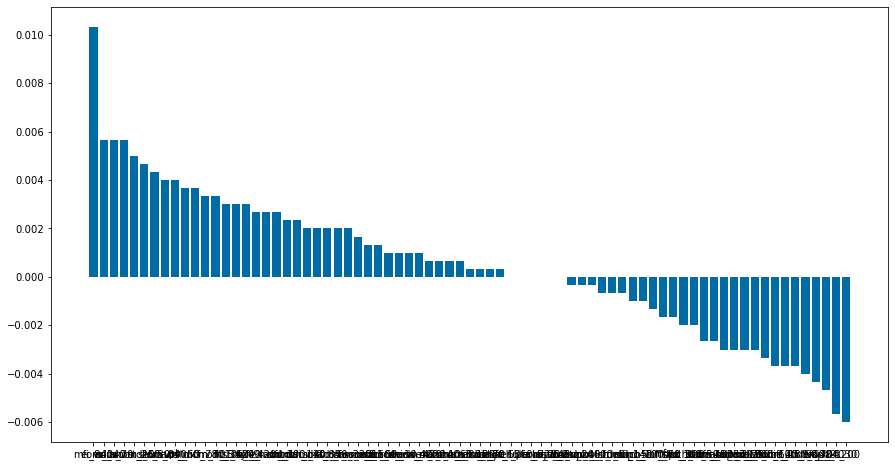

In [49]:
plt.figure(figsize=(15,8))
plt.bar(fi.index,fi.importance)
plt.show()

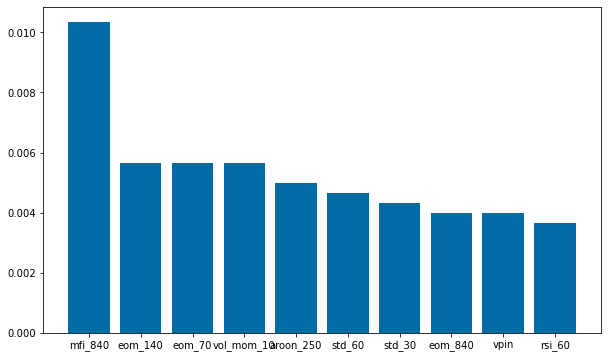

In [50]:
fi_top = fi.head(10)
plt.figure(figsize=(10,6))
plt.bar(fi_top.index,fi_top.importance)
plt.show()

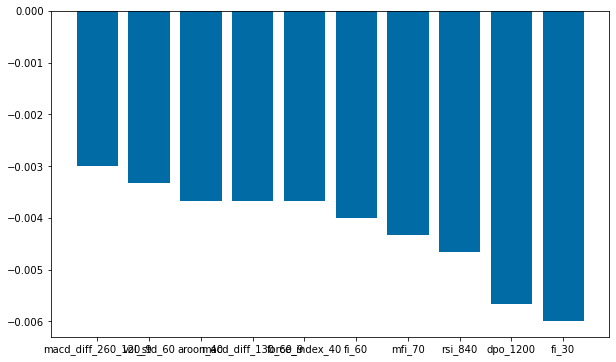

In [51]:
fi_bottom = fi.tail(10)
plt.figure(figsize=(10,6))
plt.bar(fi_bottom.index,fi_bottom.importance)
plt.show()

In [53]:
fi['rank'] = np.arange(len(fi))
fi

,importance,stddev,p_value,n,p99_high,p99_low,rank
mfi_840,0.010333,0.004933,0.034137,3,0.038599,-0.017933,0
eom_140,0.005667,0.007638,0.163745,3,0.049431,-0.038098,1
eom_70,0.005667,0.008737,0.189001,3,0.055730,-0.044397,2
vol_mom_10,0.005667,0.002309,0.025576,3,0.018900,-0.007566,3
aroon_250,0.005000,0.006083,0.145262,3,0.039855,-0.029855,4
...,...,...,...,...,...,...,...
fi_60,-0.004000,0.005196,0.842997,3,0.025775,-0.033775,70
mfi_70,-0.004333,0.003055,0.933333,3,0.013172,-0.021839,71
rsi_840,-0.004667,0.005774,0.851763,3,0.028416,-0.037749,72
dpo_1200,-0.005667,0.018037,0.679555,3,0.097687,-0.109021,73


In [60]:
rank = fi.rank()['rank']

In [62]:
rank.index

Index(['mfi_840', 'eom_140', 'eom_70', 'vol_mom_10', 'aroon_250', 'std_60',
       'std_30', 'eom_840', 'vpin', 'rsi_60', 'vol_mom_30',
       'macd_diff_780_360_9', 'mom_5', 'fi_10', 'rsi_420', 'rsi_40', 'mfi_420',
       'kyle_lambda', 'mom_1', 'std_100', 'of_mom_30', 'rsi_140',
       'stoch_diff_840_3', 'std_5', 'sma_cross_20', 'vol_mom_5', 'of_mom_1',
       'aroon_1500', 'eom_60', 'of_mom_10', 'sma_cross_40', 'force_index_20',
       'eom_420', 'stoch_diff_140_3', 'mom_10', 'aroon_60', 'mom_30',
       'sma_cross_60', 'rsi_20', 'rsi_70', 'bbpi_60', 'macd_diff_1560_720_9',
       'corwin_schultz_estimator', 'bekker_parkinson_vol', 'eom_20', 'bbpi_40',
       'fi_5', 'aroon_20', 'eom_40', 'dpo_600', 'vol_std_5', 'vol_mom_1',
       'of_mom_5', 'mfi_140', 'dpo_100', 'stoch_diff_70_3', 'mfv',
       'vol_std_100', 'dpo_200', 'vol_std_30', 'stoch_diff_420_3', 'aroon_125',
       'force_index_60', 'bbpi_20', 'aroon_750', 'macd_diff_260_120_9',
       'vol_std_60', 'aroon_40', 'macd_dif